In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.optim as optim

In [2]:
matplotlib.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size_train = 256
batch_size_test = 1024

# Load the MNIST Dataset

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_data = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.MNIST(
    'data/', 
    train=False, 
    download=True,
    transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    pin_memory=True,
    num_workers=6,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test, 
    pin_memory=True,
    num_workers=6,
    shuffle=True)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

# train_data.train_data.to(device)  # put data into GPU entirely
# train_data.train_labels.to(device)

# test_data.test_data.to(device)  # put data into GPU entirely
# test_data.test_labels.to(device)

Train size: 60000
Test size: 10000


In [5]:
train_data.data.is_cuda

False

## Visualizing

In [6]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([256, 1, 28, 28])

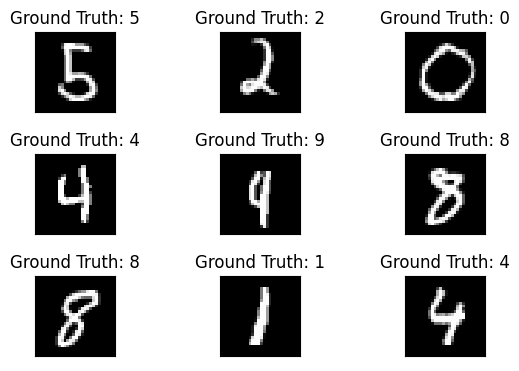

In [7]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(f"Ground Truth: {example_targets[i]}")
  plt.xticks([])
  plt.yticks([])

# Architecture

## Flattening
<figure>
    <img src="images/mnist_flatten.png" alt="A kitten">
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure>  

## Matrix Representation
<figure>
    <img src="images/mnist_matrix_multiplication_batch.png" alt="A kitten">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

# How do we measure success?

## Step 1: Compute distance between computed value and actual value
<figure>
    <img src="images/cross_entropy.png" alt="loss_function">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

## Step 2: Take a step to reduce that distance
<figure>
    <img src="images/gradient_descent.png" alt="loss_function">
    <br><br>
    <figcaption>Source: https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/ <figcaption>
<figure> 

# Code implementation

In [8]:
def one_train_epoch(train_data, model, loss_fn, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU
        data = data.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        
        # Flatten Data
        data = data.view(-1, 784)
        optimizer.zero_grad()
        
        # Predictions
        output = model(data)
        
        # Compute Loss
        train_loss = loss_fn(output, target)
        
        # Track metrics
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).sum().cpu()
        train_accuracy.append(correct/len(data))
        train_losses.append(train_loss.item())
        train_counter.append(batch_idx*batch_size_train + epoch*len(train_loader.dataset))
        
        if batch_idx % 10 == 0:
            print(f"loss: {train_loss.item():>7f}  [{batch_idx * len(data):>5d}/{len(train_loader.dataset):>5d}]")
        
        # Backprop
        train_loss.backward()
        optimizer.step()
    return train_loss

In [9]:
def test(test_data, model, loss_fn, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_data:
            data = data.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
            data = data.view(-1, 784)
            output = model(data)
            test_loss += loss_fn(output, target, reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().cpu()
            
    test_loss /= len(test_loader.dataset)
    
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    test_counter.append(epoch*len(train_loader.dataset))
    print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n')

## Training hyperparameters

In [10]:
epochs = 35
learning_rate = 0.01

loss_fn = nn.functional.nll_loss

## Training a v1 model

In [11]:
class NeuralNetwork_v1(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, n_classes)
        )
    def forward(self, x):
        output = self.nn_stack(x)
        
        # compute softmax
        output = nn.functional.log_softmax(output)
        return output

In [12]:
model = NeuralNetwork_v1(784, 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr = learning_rate, 
                            )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses = []
train_accuracy = []
train_counter = []

test_losses = []
test_accuracy = []
test_counter = []

test(test_loader, model, loss_fn, 0)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
    test(test_loader, model, loss_fn, epoch+1)
print("Done!")

/tmp/ipykernel_212483/3146421046.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.functional.log_softmax(output)



Test set: Avg. loss: 2.4040, Accuracy: 1145/10000 (11.45%)

Epoch 1, lr: 0.01
-------------------------------
loss: 2.373351  [    0/60000]
loss: 0.528018  [ 2560/60000]
loss: 0.497017  [ 5120/60000]
loss: 0.447331  [ 7680/60000]
loss: 0.389051  [10240/60000]
loss: 0.386032  [12800/60000]
loss: 0.532265  [15360/60000]
loss: 0.325317  [17920/60000]
loss: 0.395037  [20480/60000]
loss: 0.214275  [23040/60000]
loss: 0.269662  [25600/60000]
loss: 0.411095  [28160/60000]
loss: 0.232721  [30720/60000]
loss: 0.316696  [33280/60000]
loss: 0.284909  [35840/60000]
loss: 0.323192  [38400/60000]
loss: 0.371665  [40960/60000]
loss: 0.322733  [43520/60000]
loss: 0.395824  [46080/60000]
loss: 0.261316  [48640/60000]
loss: 0.374363  [51200/60000]
loss: 0.273360  [53760/60000]
loss: 0.377672  [56320/60000]
loss: 0.427814  [58880/60000]

Test set: Avg. loss: 0.3403, Accuracy: 9021/10000 (90.21%)

Epoch 2, lr: 0.01
-------------------------------
loss: 0.381136  [    0/60000]
loss: 0.377537  [ 2560/60000

loss: 0.239270  [46080/60000]
loss: 0.293534  [48640/60000]
loss: 0.210754  [51200/60000]
loss: 0.399805  [53760/60000]
loss: 0.154574  [56320/60000]
loss: 0.263337  [58880/60000]

Test set: Avg. loss: 0.2781, Accuracy: 9250/10000 (92.50%)

Epoch 11, lr: 0.001
-------------------------------
loss: 0.236706  [    0/60000]
loss: 0.121437  [ 2560/60000]
loss: 0.224238  [ 5120/60000]
loss: 0.245120  [ 7680/60000]
loss: 0.264521  [10240/60000]
loss: 0.262285  [12800/60000]
loss: 0.318987  [15360/60000]
loss: 0.190049  [17920/60000]
loss: 0.359344  [20480/60000]
loss: 0.264984  [23040/60000]
loss: 0.212541  [25600/60000]
loss: 0.257058  [28160/60000]
loss: 0.333294  [30720/60000]
loss: 0.179250  [33280/60000]
loss: 0.331544  [35840/60000]
loss: 0.174055  [38400/60000]
loss: 0.231595  [40960/60000]
loss: 0.156629  [43520/60000]
loss: 0.218147  [46080/60000]
loss: 0.307955  [48640/60000]
loss: 0.192809  [51200/60000]
loss: 0.123165  [53760/60000]
loss: 0.209574  [56320/60000]
loss: 0.302743  [

loss: 0.193683  [30720/60000]
loss: 0.254723  [33280/60000]
loss: 0.339426  [35840/60000]
loss: 0.265569  [38400/60000]
loss: 0.355421  [40960/60000]
loss: 0.197165  [43520/60000]
loss: 0.237565  [46080/60000]
loss: 0.190847  [48640/60000]
loss: 0.223846  [51200/60000]
loss: 0.314822  [53760/60000]
loss: 0.350454  [56320/60000]
loss: 0.209380  [58880/60000]
Epoch    20: reducing learning rate of group 0 to 1.0000e-06.

Test set: Avg. loss: 0.2730, Accuracy: 9264/10000 (92.64%)

Epoch 21, lr: 1.0000000000000002e-06
-------------------------------
loss: 0.221650  [    0/60000]
loss: 0.243248  [ 2560/60000]
loss: 0.178156  [ 5120/60000]
loss: 0.307883  [ 7680/60000]
loss: 0.233954  [10240/60000]
loss: 0.218483  [12800/60000]
loss: 0.244376  [15360/60000]
loss: 0.185769  [17920/60000]
loss: 0.251496  [20480/60000]
loss: 0.196152  [23040/60000]
loss: 0.182765  [25600/60000]
loss: 0.256181  [28160/60000]
loss: 0.207062  [30720/60000]
loss: 0.296468  [33280/60000]
loss: 0.265325  [35840/60000


Test set: Avg. loss: 0.2729, Accuracy: 9264/10000 (92.64%)

Epoch 30, lr: 1.0000000000000004e-08
-------------------------------
loss: 0.349304  [    0/60000]
loss: 0.322405  [ 2560/60000]
loss: 0.388894  [ 5120/60000]
loss: 0.217522  [ 7680/60000]
loss: 0.233114  [10240/60000]
loss: 0.236866  [12800/60000]
loss: 0.172998  [15360/60000]
loss: 0.169683  [17920/60000]
loss: 0.299966  [20480/60000]
loss: 0.268997  [23040/60000]
loss: 0.188573  [25600/60000]
loss: 0.209920  [28160/60000]
loss: 0.214575  [30720/60000]
loss: 0.193242  [33280/60000]
loss: 0.187906  [35840/60000]
loss: 0.114379  [38400/60000]
loss: 0.234544  [40960/60000]
loss: 0.301472  [43520/60000]
loss: 0.254080  [46080/60000]
loss: 0.255163  [48640/60000]
loss: 0.168257  [51200/60000]
loss: 0.207997  [53760/60000]
loss: 0.156018  [56320/60000]
loss: 0.207997  [58880/60000]

Test set: Avg. loss: 0.2729, Accuracy: 9264/10000 (92.64%)

Epoch 31, lr: 1.0000000000000004e-08
-------------------------------
loss: 0.222653  [   

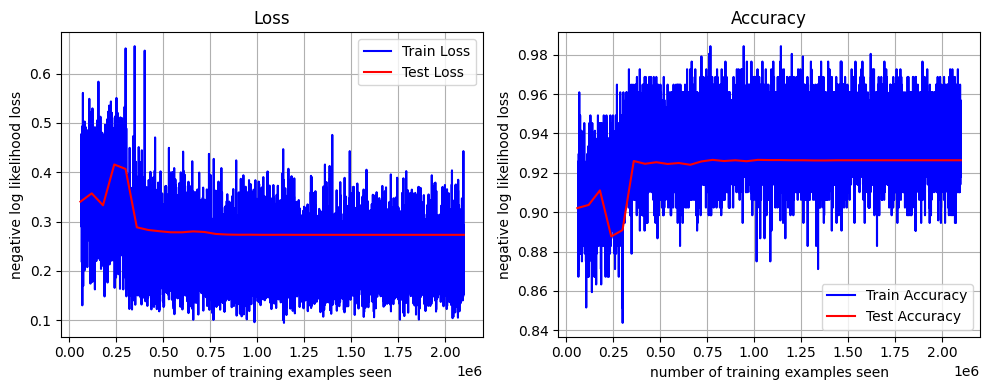

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(train_counter[250:], train_losses[250:], label = "Train Loss", color='blue')
ax[0].plot(test_counter[1:], test_losses[1:], label = "Test Loss", color='red')
ax[0].set_title("Loss")
ax[0].legend(loc="upper right")
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative log likelihood loss')
ax[0].grid(True)

ax[1].plot(train_counter[250:], train_accuracy[250:], label = "Train Accuracy", color='blue')
ax[1].plot(test_counter[1:], test_accuracy[1:], label = "Test Accuracy", color='red')
ax[1].set_title("Accuracy")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('negative log likelihood loss')
ax[1].grid(True)
plt.tight_layout(h_pad=5)

# Deep Learning! Let's try adding some more layers

<figure>
    <img src="images/go_deep!.png" alt="Deep Leanring">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

## How about 5? 

<figure>
    <img src="images/add_more_layers.png" alt="Deep Learning">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

In [14]:
class NeuralNetwork_v2(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, n_classes),
        )
    def forward(self, x):
        output = self.nn_stack(x)
        
        # compute softmax
        output = nn.functional.log_softmax(output)
        return output

In [15]:
model = NeuralNetwork_v2(784, 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr = learning_rate, 
                            )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)


train_losses = []
train_accuracy = []
train_counter = []

test_losses = []
test_accuracy = []
test_counter = []

test(test_loader, model, loss_fn, 0)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
    test(test_loader, model, loss_fn, epoch+1)
print("Done!")


Test set: Avg. loss: 2.3050, Accuracy: 995/10000 (9.95%)

Epoch 1, lr: 0.01
-------------------------------


/tmp/ipykernel_212483/3683493287.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.functional.log_softmax(output)


loss: 2.304501  [    0/60000]
loss: 1.105660  [ 2560/60000]
loss: 0.601307  [ 5120/60000]
loss: 0.563885  [ 7680/60000]
loss: 0.341744  [10240/60000]
loss: 0.239941  [12800/60000]
loss: 0.338917  [15360/60000]
loss: 0.409632  [17920/60000]
loss: 0.318687  [20480/60000]
loss: 0.173115  [23040/60000]
loss: 0.218750  [25600/60000]
loss: 0.283897  [28160/60000]
loss: 0.167013  [30720/60000]
loss: 0.161420  [33280/60000]
loss: 0.234543  [35840/60000]
loss: 0.280160  [38400/60000]
loss: 0.181488  [40960/60000]
loss: 0.088351  [43520/60000]
loss: 0.142667  [46080/60000]
loss: 0.111577  [48640/60000]
loss: 0.179214  [51200/60000]
loss: 0.218716  [53760/60000]
loss: 0.150683  [56320/60000]
loss: 0.154983  [58880/60000]

Test set: Avg. loss: 0.1832, Accuracy: 9484/10000 (94.84%)

Epoch 2, lr: 0.01
-------------------------------
loss: 0.163364  [    0/60000]
loss: 0.093720  [ 2560/60000]
loss: 0.160616  [ 5120/60000]
loss: 0.243567  [ 7680/60000]
loss: 0.153573  [10240/60000]
loss: 0.193406  [12

Epoch    10: reducing learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 0.1209, Accuracy: 9743/10000 (97.43%)

Epoch 11, lr: 0.001
-------------------------------
loss: 0.037238  [    0/60000]
loss: 0.051363  [ 2560/60000]
loss: 0.029581  [ 5120/60000]
loss: 0.017290  [ 7680/60000]
loss: 0.062276  [10240/60000]
loss: 0.060043  [12800/60000]
loss: 0.060046  [15360/60000]
loss: 0.015080  [17920/60000]
loss: 0.036042  [20480/60000]
loss: 0.028593  [23040/60000]
loss: 0.029401  [25600/60000]
loss: 0.060566  [28160/60000]
loss: 0.036918  [30720/60000]
loss: 0.016901  [33280/60000]
loss: 0.045347  [35840/60000]
loss: 0.044286  [38400/60000]
loss: 0.005171  [40960/60000]
loss: 0.011698  [43520/60000]
loss: 0.018821  [46080/60000]
loss: 0.049007  [48640/60000]
loss: 0.013965  [51200/60000]
loss: 0.012860  [53760/60000]
loss: 0.026995  [56320/60000]
loss: 0.024565  [58880/60000]

Test set: Avg. loss: 0.0946, Accuracy: 9814/10000 (98.14%)

Epoch 12, lr: 0.001
------------------------

loss: 0.001182  [46080/60000]
loss: 0.032003  [48640/60000]
loss: 0.034347  [51200/60000]
loss: 0.001068  [53760/60000]
loss: 0.000057  [56320/60000]
loss: 0.000902  [58880/60000]

Test set: Avg. loss: 0.1254, Accuracy: 9828/10000 (98.28%)

Epoch 21, lr: 0.001
-------------------------------
loss: 0.000195  [    0/60000]
loss: 0.000455  [ 2560/60000]
loss: 0.004672  [ 5120/60000]
loss: 0.001961  [ 7680/60000]
loss: 0.000909  [10240/60000]
loss: 0.003032  [12800/60000]
loss: 0.003540  [15360/60000]
loss: 0.000699  [17920/60000]
loss: 0.000168  [20480/60000]
loss: 0.014330  [23040/60000]
loss: 0.006266  [25600/60000]
loss: 0.000513  [28160/60000]
loss: 0.000037  [30720/60000]
loss: 0.007955  [33280/60000]
loss: 0.000305  [35840/60000]
loss: 0.001764  [38400/60000]
loss: 0.007234  [40960/60000]
loss: 0.001878  [43520/60000]
loss: 0.002101  [46080/60000]
loss: 0.007692  [48640/60000]
loss: 0.003830  [51200/60000]
loss: 0.003112  [53760/60000]
loss: 0.000803  [56320/60000]
loss: 0.010342  [

loss: 0.000528  [28160/60000]
loss: 0.000054  [30720/60000]
loss: 0.001039  [33280/60000]
loss: 0.000271  [35840/60000]
loss: 0.002039  [38400/60000]
loss: 0.018824  [40960/60000]
loss: 0.001064  [43520/60000]
loss: 0.000688  [46080/60000]
loss: 0.000380  [48640/60000]
loss: 0.000065  [51200/60000]
loss: 0.000207  [53760/60000]
loss: 0.000812  [56320/60000]
loss: 0.005249  [58880/60000]

Test set: Avg. loss: 0.1357, Accuracy: 9829/10000 (98.29%)

Epoch 31, lr: 1e-05
-------------------------------
loss: 0.000445  [    0/60000]
loss: 0.000354  [ 2560/60000]
loss: 0.000046  [ 5120/60000]
loss: 0.000185  [ 7680/60000]
loss: 0.001275  [10240/60000]
loss: 0.000389  [12800/60000]
loss: 0.005846  [15360/60000]
loss: 0.000372  [17920/60000]
loss: 0.000296  [20480/60000]
loss: 0.000071  [23040/60000]
loss: 0.002073  [25600/60000]
loss: 0.017071  [28160/60000]
loss: 0.001387  [30720/60000]
loss: 0.000336  [33280/60000]
loss: 0.000263  [35840/60000]
loss: 0.000111  [38400/60000]
loss: 0.001256  [

In [16]:
print(f"Peak Test Accuracy :{max(test_accuracy)}")
print(f"Peak Train Accuracy :{max(train_accuracy)}")

Peak Test Accuracy :0.9829999804496765
Peak Train Accuracy :1.0


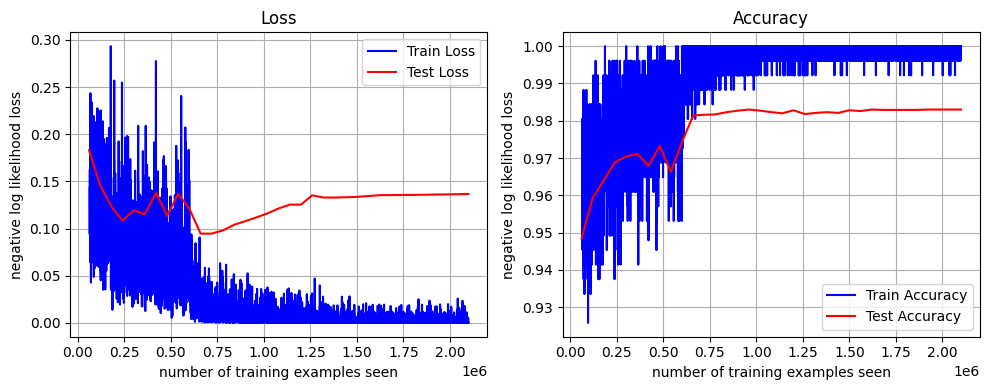

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(train_counter[250:], train_losses[250:], label = "Train Loss", color='blue')
ax[0].plot(test_counter[1:], test_losses[1:], label = "Test Loss", color='red')
ax[0].set_title("Loss")
ax[0].legend(loc="upper right")
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative log likelihood loss')
ax[0].grid(True)

ax[1].plot(train_counter[250:], train_accuracy[250:], label = "Train Accuracy", color='blue')
ax[1].plot(test_counter[1:], test_accuracy[1:], label = "Test Accuracy", color='red')
ax[1].set_title("Accuracy")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('negative log likelihood loss')
ax[1].grid(True)
plt.tight_layout(h_pad=5)

In [18]:
class NeuralNetwork_v3(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(30, n_classes),
        )
    def forward(self, x):
        output = self.nn_stack(x)
        
        # compute softmax
        output = nn.functional.log_softmax(output)
        return output

In [19]:
model = NeuralNetwork_v3(784, 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr = learning_rate, 
                            )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)


train_losses = []
train_accuracy = []
train_counter = []

test_losses = []
test_accuracy = []
test_counter = []

test(test_loader, model, loss_fn, 0)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
    test(test_loader, model, loss_fn, epoch+1)
print("Done!")

/tmp/ipykernel_212483/1672172756.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = nn.functional.log_softmax(output)



Test set: Avg. loss: 2.3054, Accuracy: 1009/10000 (10.09%)

Epoch 1, lr: 0.01
-------------------------------
loss: 2.310413  [    0/60000]
loss: 1.425493  [ 2560/60000]
loss: 1.101273  [ 5120/60000]
loss: 0.881920  [ 7680/60000]
loss: 0.657496  [10240/60000]
loss: 0.438422  [12800/60000]
loss: 0.520997  [15360/60000]
loss: 0.337204  [17920/60000]
loss: 0.538363  [20480/60000]
loss: 0.642185  [23040/60000]
loss: 0.328528  [25600/60000]
loss: 0.436440  [28160/60000]
loss: 0.583736  [30720/60000]
loss: 0.525013  [33280/60000]
loss: 0.427504  [35840/60000]
loss: 0.341072  [38400/60000]
loss: 0.353312  [40960/60000]
loss: 0.369596  [43520/60000]
loss: 0.416774  [46080/60000]
loss: 0.276236  [48640/60000]
loss: 0.379778  [51200/60000]
loss: 0.505652  [53760/60000]
loss: 0.425428  [56320/60000]
loss: 0.405362  [58880/60000]

Test set: Avg. loss: 0.2478, Accuracy: 9353/10000 (93.53%)

Epoch 2, lr: 0.01
-------------------------------
loss: 0.605865  [    0/60000]
loss: 0.368690  [ 2560/60000

loss: 0.172388  [46080/60000]
loss: 0.210518  [48640/60000]
loss: 0.169618  [51200/60000]
loss: 0.104262  [53760/60000]
loss: 0.154484  [56320/60000]
loss: 0.104311  [58880/60000]

Test set: Avg. loss: 0.1356, Accuracy: 9720/10000 (97.20%)

Epoch 11, lr: 0.001
-------------------------------
loss: 0.207878  [    0/60000]
loss: 0.209391  [ 2560/60000]
loss: 0.110942  [ 5120/60000]
loss: 0.169186  [ 7680/60000]
loss: 0.232125  [10240/60000]
loss: 0.139548  [12800/60000]
loss: 0.097760  [15360/60000]
loss: 0.203650  [17920/60000]
loss: 0.095144  [20480/60000]
loss: 0.140418  [23040/60000]
loss: 0.135572  [25600/60000]
loss: 0.154242  [28160/60000]
loss: 0.139385  [30720/60000]
loss: 0.191927  [33280/60000]
loss: 0.196604  [35840/60000]
loss: 0.111483  [38400/60000]
loss: 0.106455  [40960/60000]
loss: 0.178191  [43520/60000]
loss: 0.263424  [46080/60000]
loss: 0.131997  [48640/60000]
loss: 0.116150  [51200/60000]
loss: 0.209678  [53760/60000]
loss: 0.114907  [56320/60000]
loss: 0.148847  [

loss: 0.127411  [35840/60000]
loss: 0.110440  [38400/60000]
loss: 0.154446  [40960/60000]
loss: 0.052967  [43520/60000]
loss: 0.113139  [46080/60000]
loss: 0.121896  [48640/60000]
loss: 0.088309  [51200/60000]
loss: 0.042684  [53760/60000]
loss: 0.089014  [56320/60000]
loss: 0.141741  [58880/60000]

Test set: Avg. loss: 0.1198, Accuracy: 9743/10000 (97.43%)

Epoch 21, lr: 0.0001
-------------------------------
loss: 0.042178  [    0/60000]
loss: 0.140390  [ 2560/60000]
loss: 0.075685  [ 5120/60000]
loss: 0.107354  [ 7680/60000]
loss: 0.108736  [10240/60000]
loss: 0.101354  [12800/60000]
loss: 0.116200  [15360/60000]
loss: 0.187829  [17920/60000]
loss: 0.100025  [20480/60000]
loss: 0.089701  [23040/60000]
loss: 0.153099  [25600/60000]
loss: 0.081484  [28160/60000]
loss: 0.043803  [30720/60000]
loss: 0.134214  [33280/60000]
loss: 0.081165  [35840/60000]
loss: 0.155032  [38400/60000]
loss: 0.104923  [40960/60000]
loss: 0.194542  [43520/60000]
loss: 0.055886  [46080/60000]
loss: 0.093583  

loss: 0.179836  [15360/60000]
loss: 0.129850  [17920/60000]
loss: 0.133003  [20480/60000]
loss: 0.089199  [23040/60000]
loss: 0.057262  [25600/60000]
loss: 0.202024  [28160/60000]
loss: 0.098438  [30720/60000]
loss: 0.081264  [33280/60000]
loss: 0.143924  [35840/60000]
loss: 0.162034  [38400/60000]
loss: 0.106682  [40960/60000]
loss: 0.082259  [43520/60000]
loss: 0.089992  [46080/60000]
loss: 0.091879  [48640/60000]
loss: 0.156947  [51200/60000]
loss: 0.088170  [53760/60000]
loss: 0.122371  [56320/60000]
loss: 0.055532  [58880/60000]

Test set: Avg. loss: 0.1226, Accuracy: 9750/10000 (97.50%)

Epoch 31, lr: 1.0000000000000002e-06
-------------------------------
loss: 0.068728  [    0/60000]
loss: 0.068989  [ 2560/60000]
loss: 0.081151  [ 5120/60000]
loss: 0.158384  [ 7680/60000]
loss: 0.067111  [10240/60000]
loss: 0.072948  [12800/60000]
loss: 0.138465  [15360/60000]
loss: 0.121275  [17920/60000]
loss: 0.104905  [20480/60000]
loss: 0.120389  [23040/60000]
loss: 0.060445  [25600/60000]


In [20]:
print(f"Peak Test Accuracy :{max(test_accuracy)}")
print(f"Peak Train Accuracy :{max(train_accuracy)}")

Peak Test Accuracy :0.9750000238418579
Peak Train Accuracy :1.0


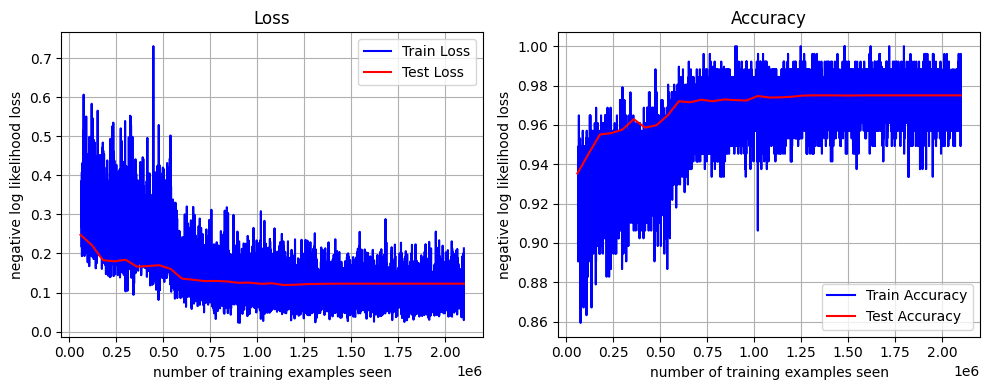

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(train_counter[250:], train_losses[250:], label = "Train Loss", color='blue')
ax[0].plot(test_counter[1:], test_losses[1:], label = "Test Loss", color='red')
ax[0].set_title("Loss")
ax[0].legend(loc="upper right")
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative log likelihood loss')
ax[0].grid(True)

ax[1].plot(train_counter[250:], train_accuracy[250:], label = "Train Accuracy", color='blue')
ax[1].plot(test_counter[1:], test_accuracy[1:], label = "Test Accuracy", color='red')
ax[1].set_title("Accuracy")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('negative log likelihood loss')
ax[1].grid(True)
plt.tight_layout(h_pad=5)

### References
[1] A lot of the material is taken/inspired from Martin Gorner's presentation https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd
<br>
[2] https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/